# **NLP Project 2 : Supervised Learning**
## Léo RINGEISSEN and Santiago MARTIN

# Library Importations

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Data Import and Aggregation

In [18]:
# Step 1: Gather all Excel file paths
file_paths = glob.glob("Traduction avis clients/*.xlsx")

# Step 2: Load and combine files
dataframes = []
for file in file_paths:
    df = pd.read_excel(file)
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Select relevant columns
selected_columns = ["note", "produit", "type", "avis_en"]  # French column names
combined_df = combined_df[selected_columns]

# Rename columns to English
combined_df.columns = ["rating", "product", "type", "review"]

# Manual Translation of `product` Column

In [19]:
# Correct product translations
product_translations = {
    "animaux": "animals",
    "auto": "car",
    "credit": "credit",
    "garantie-decennale": "ten-year warranty",
    "habitation": "home",
    "moto": "motorcycle",
    "multirisque-professionnelle": "professional multi-risk",
    "prevoyance": "accidental injury",
    "responsabilite-civile-professionnelle": "professional liability",
    "sante": "health",
    "vie": "life"
}

# Apply translations to `product` column
combined_df["product"] = combined_df["product"].map(product_translations)

# Clean English Reviews

In [20]:
# Remove faulty reviews and clean the text
combined_df["review"] = (
    combined_df["review"]
    .str.replace(r"\s+", " ", regex=True)  # Replace extra spaces and newlines with a single space
    .str.strip()  # Remove leading/trailing spaces
)

# Filter out rows with "Loading..."
combined_df = combined_df[~combined_df["review"].str.contains("Loading...", na=False)]

# Removing null values (focus on ratings)

In [21]:
print(combined_df.isnull().sum())
combined_df.dropna(inplace=True)
print(combined_df.isnull().sum())

rating     9782
product      16
type          0
review        2
dtype: int64
rating     0
product    0
type       0
review     0
dtype: int64


# Summary of Cleaned Data

In [22]:
print("Total rows and columns:", combined_df.shape)

Total rows and columns: (23539, 4)



Unique ratings and counts:
rating
1.0    7094
4.0    4771
5.0    4745
2.0    3635
3.0    3294
Name: count, dtype: int64


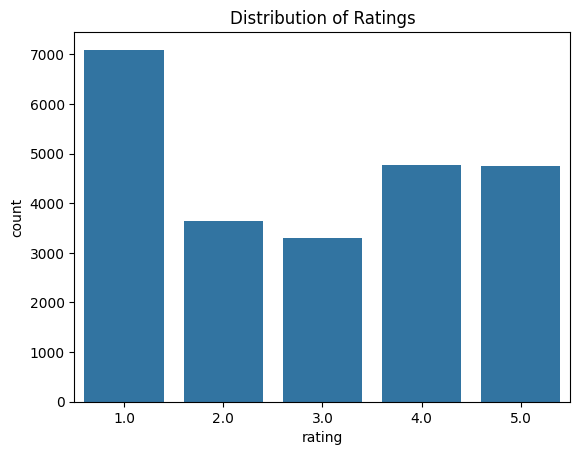

In [23]:
print("\nUnique ratings and counts:")
print(combined_df["rating"].value_counts())

sns.countplot(x="rating", data=combined_df)
plt.title("Distribution of Ratings")
plt.show()


Unique product categories and counts:
product
car                        13745
health                      3443
motorcycle                  2063
home                        1922
accidental injury            768
credit                       640
life                         559
animals                      364
professional multi-risk       19
ten-year warranty             11
professional liability         5
Name: count, dtype: int64


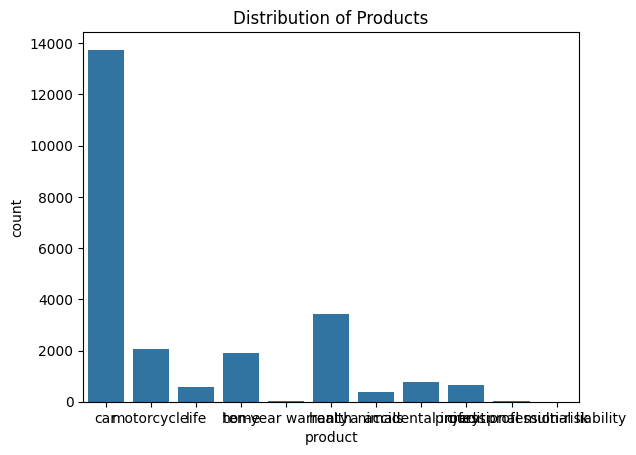

In [24]:
print("\nUnique product categories and counts:")
print(combined_df["product"].value_counts())

sns.countplot(x="product", data=combined_df)
plt.title("Distribution of Products")
plt.show()


Count of products per rating:
rating  product                
1.0     car                        2948
        health                     1381
        home                       1054
        accidental injury           506
        life                        395
        motorcycle                  309
        credit                      265
        animals                     214
        ten-year warranty             9
        professional multi-risk       8
        professional liability        5
2.0     car                        2049
        home                        526
        health                      431
        motorcycle                  264
        accidental injury           115
        credit                       95
        life                         84
        animals                      70
        professional multi-risk       1
3.0     car                        2096
        health                      522
        motorcycle                  263
        home     

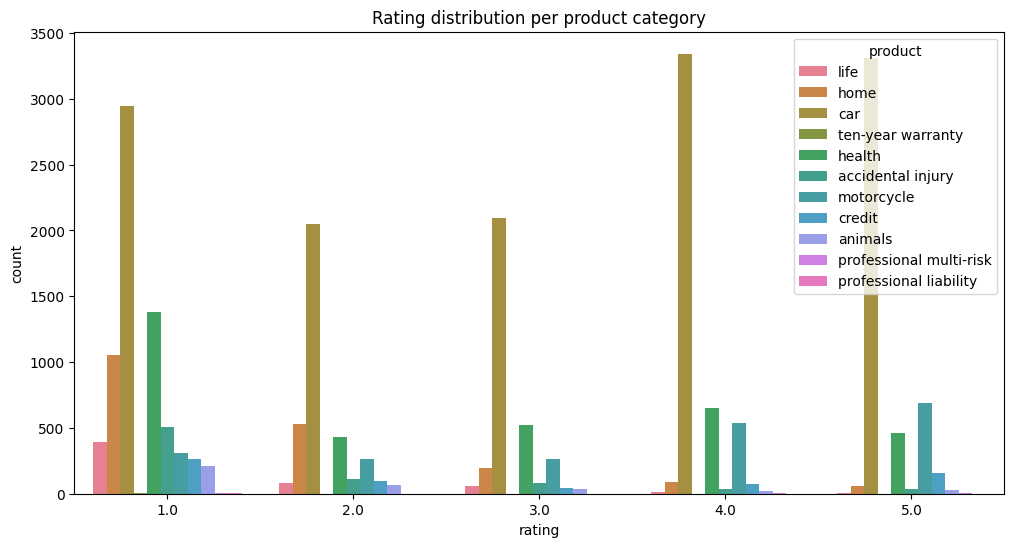

In [25]:
print("\nCount of products per rating:")
print(combined_df.groupby("rating")["product"].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x="rating", hue="product")
plt.title("Rating distribution per product category")
plt.show()

In [26]:
print("\nSample data:")
display(combined_df.head())


Sample data:


,rating,product,type,review
0,4.0,car,train,The person on the phone was clear and friendly...
1,4.0,motorcycle,train,"Satisfied. Reactivity, simplicity. Attractive ..."
2,1.0,life,train,"Insurer to flee, does not ensure its responsib..."
3,1.0,home,train,The GMF has been waiting for a water damage fo...
4,3.0,car,train,I am good with this insurance. She is practica...


In [27]:
combined_df.to_csv("combined_reviews.csv", index=False)

# Exploratory Data Analysis and Word Frequency

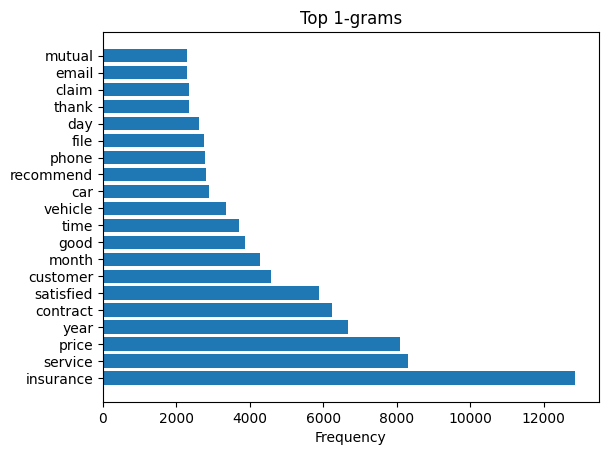

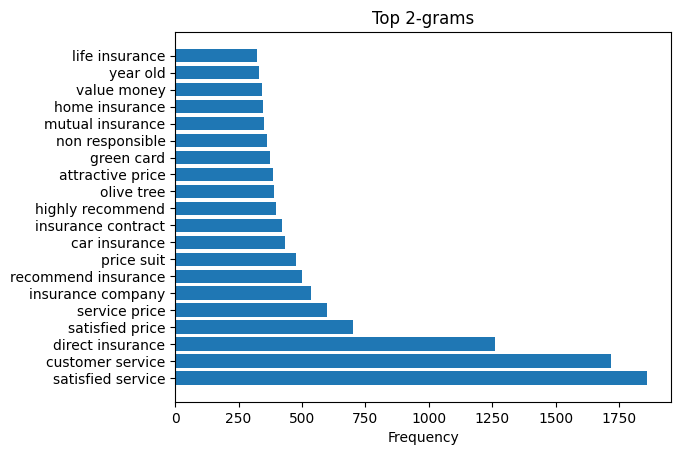

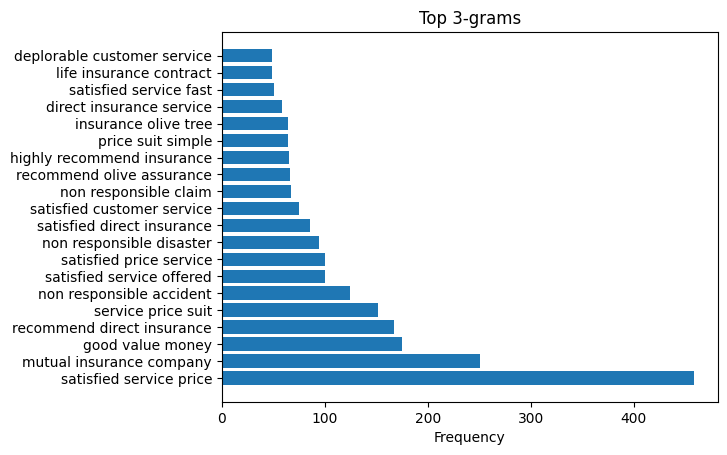

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate n-grams
def plot_ngrams(reviews, n=1, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(reviews)
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_words = vectorizer.get_feature_names_out()
    ngram_data = sorted(zip(ngram_freq, ngram_words), reverse=True)[:top_n]
    
    plt.barh([x[1] for x in ngram_data], [x[0] for x in ngram_data])
    plt.xlabel("Frequency")
    plt.title(f"Top {n}-grams")
    plt.show()

# Plot frequent words and bigrams
plot_ngrams(combined_df['review'], n=1)  # Unigrams
plot_ngrams(combined_df['review'], n=2)  # Bigrams
plot_ngrams(combined_df['review'], n=3)  # Trigrams

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(combined_df['review']))

# Preprocessing reviews

In [28]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    """Cleans and preprocesses text data."""
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Lemmatize words
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    # Stem words (optional, depending on need)
    # text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

processed_df = combined_df.copy()

# Apply preprocessing to the review column
processed_df['review'] = combined_df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# Check a sample of the preprocessed reviews
display(combined_df['review'].head())
display(processed_df['review'].head())

0    The person on the phone was clear and friendly...
1    Satisfied. Reactivity, simplicity. Attractive ...
2    Insurer to flee, does not ensure its responsib...
3    The GMF has been waiting for a water damage fo...
4    I am good with this insurance. She is practica...
Name: review, dtype: object

0    person phone clear friendly explained everythi...
1    satisfied reactivity simplicity attractive pri...
2    insurer flee ensure responsibility insurance a...
3    gmf waiting water damage 3 month several contr...
4    good insurance practical least find miurre ins...
Name: review, dtype: object

# Model testing

## Functions for efficiency

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sentence_transformers import SentenceTransformer
import numpy as np

# Data Preparation Methods
def data_prep_tfidf(df):
    """Prepares data using TF-IDF vectorization."""
    tfidf = TfidfVectorizer(max_features=5000)
    X = tfidf.fit_transform(df['review'])
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def data_prep_word2vec(df):
    """Prepares data using Word2Vec embeddings."""
    sentences = [review.split() for review in df['review']]
    w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    # Convert each review into the mean of its word embeddings
    X = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(100)], axis=0) for sentence in sentences])
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


def data_prep_sentence_bert(df):
    """Prepares data using Sentence BERT embeddings."""
    sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    X = sbert_model.encode(df['review'].tolist())
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def train_lr_model(X_train, y_train):
    """Trains a Logistic Regression model."""
    print("Training Logistic Regression model...")
    model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
    model.fit(X_train, y_train)
    return model  

# Model Training Functions
def train_rf_model(X_train, y_train):
    """Trains a Random Forest model."""
    print("Training Random Forest model...")
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model  

# Model Evaluation
def evaluate_model(model, X_test, y_test, target_labels):
    """Evaluates a model with classification report and confusion matrix."""
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_labels))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Usage Example
# Assuming `df` is your dataframe and target_labels is a list of class names
# Uncomment the following lines to test each method:

# TF-IDF Example
# X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_features = data_prep_tfidf(df)
# model_tfidf = train_rf_model(X_train_tfidf, y_train_tfidf)
# evaluate_model(model_tfidf, X_test_tfidf, y_test_tfidf, target_labels)

# Word2Vec Example
# X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = data_prep_word2vec(df)
# model_w2v = train_lr_model(X_train_w2v, y_train_w2v)
# evaluate_model(model_w2v, X_test_w2v, y_test_w2v, target_labels)

# Sentence BERT Example
# X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert = data_prep_sentence_bert(df)
# model_sbert = train_rf_model(X_train_sbert, y_train_sbert)
# evaluate_model(model_sbert, X_test_sbert, y_test_sbert, target_labels)

## On processed df

## TDIDF

Training Logistic Regression model...


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Random Forest model...
Logistic Regression Model:
Classification Report:


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                         precision    recall  f1-score   support

      accidental injury       0.81      0.46      0.59       154
                animals       1.00      0.31      0.47        75
                    car       0.76      0.96      0.85      2679
                 credit       0.78      0.29      0.42       120
                 health       0.81      0.77      0.79       690
                   home       0.82      0.51      0.63       427
                   life       0.83      0.50      0.63       129
             motorcycle       0.90      0.33      0.49       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.78      4708
              macro avg       0.61      0.38      0.44      4708
           weighted avg       0.79      0.78      0.76      4708

Confusion Matrix:


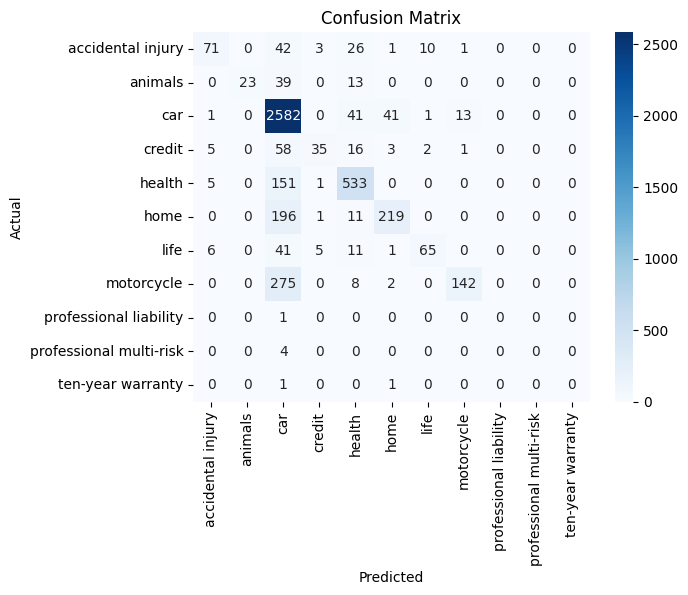

Random Forest Model:
Classification Report:
                         precision    recall  f1-score   support

      accidental injury       0.81      0.23      0.36       154
                animals       1.00      0.25      0.40        75
                    car       0.72      0.98      0.83      2679
                 credit       0.80      0.10      0.18       120
                 health       0.81      0.73      0.77       690
                   home       0.91      0.31      0.46       427
                   life       0.82      0.47      0.60       129
             motorcycle       0.91      0.27      0.42       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.75      4708
              macro avg       0.62      0.30      0.37      4708
           weighted avg       0.78      0.75

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

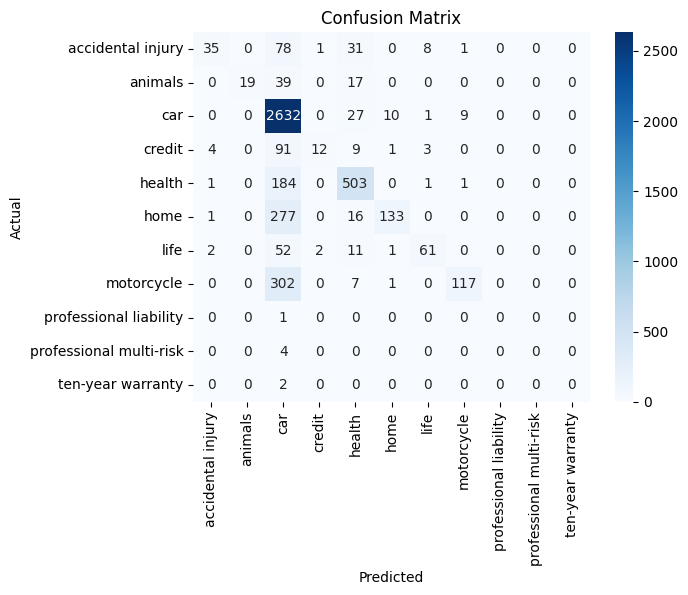

In [31]:
# Prepare data
X_train, X_test, y_train, y_test = data_prep_tfidf(processed_df)

# Train Logistic Regression model
lr_product = train_lr_model(X_train, y_train)

# Train Random Forest model
rf_product = train_rf_model(X_train, y_train)

# Evaluate Logistic Regression model
print("Logistic Regression Model:")
evaluate_model(lr_product, X_test, y_test, lr_product.classes_)

# Evaluate Random Forest model
print("Random Forest Model:")
evaluate_model(rf_product, X_test, y_test, rf_product.classes_)

## W2V

Training Logistic Regression model...


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Random Forest model...
Logistic Regression Model:
Classification Report:
                         precision    recall  f1-score   support

      accidental injury       0.39      0.19      0.26       154
                animals       0.36      0.05      0.09        75
                    car       0.71      0.93      0.81      2679
                 credit       0.60      0.03      0.05       120
                 health       0.64      0.73      0.68       690
                   home       0.65      0.37      0.47       427
                   life       0.45      0.19      0.27       129
             motorcycle       0.58      0.02      0.03       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.69      4708
              macro avg       0.40      0.23      0.24      4708
      

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

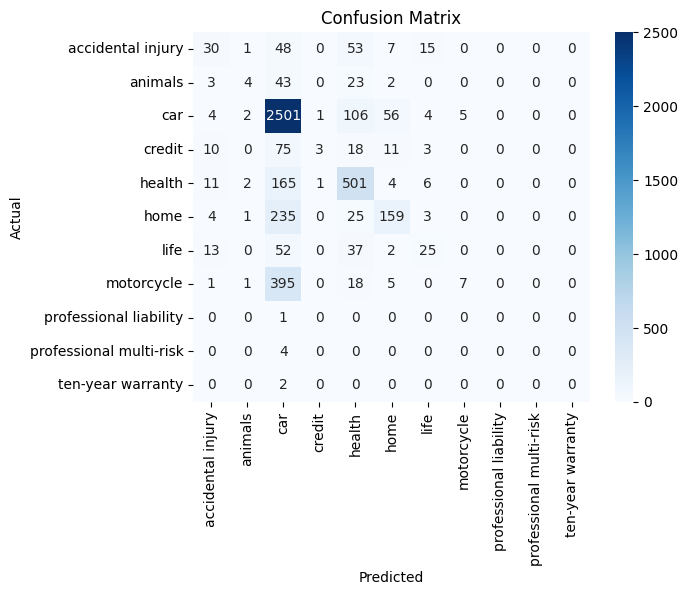

Random Forest Model:
Classification Report:


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                         precision    recall  f1-score   support

      accidental injury       0.44      0.18      0.26       154
                animals       0.00      0.00      0.00        75
                    car       0.69      0.95      0.80      2679
                 credit       0.88      0.06      0.11       120
                 health       0.60      0.65      0.62       690
                   home       0.65      0.29      0.40       427
                   life       0.50      0.04      0.07       129
             motorcycle       1.00      0.00      0.00       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.67      4708
              macro avg       0.43      0.20      0.21      4708
           weighted avg       0.68      0.67      0.60      4708

Confusion Matrix:


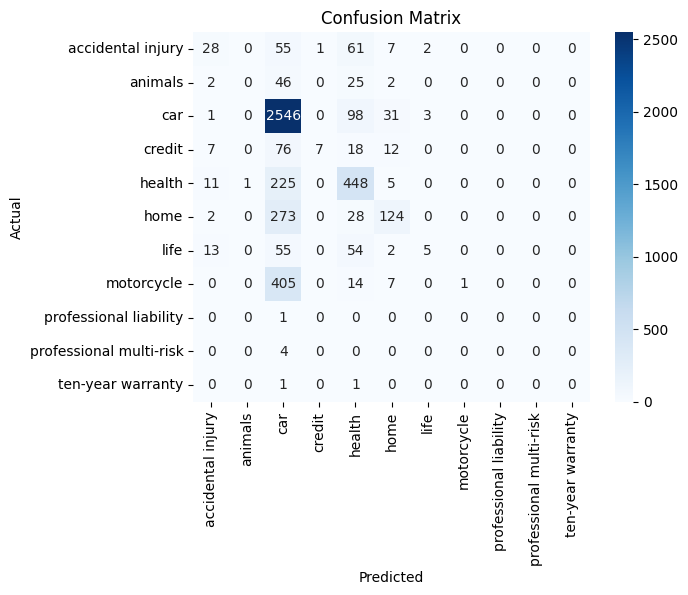

In [32]:
# Prepare data
X_train, X_test, y_train, y_test = data_prep_word2vec(processed_df)

# Train Logistic Regression model
lr_product = train_lr_model(X_train, y_train)

# Train Random Forest model
rf_product = train_rf_model(X_train, y_train)

# Evaluate Logistic Regression model
print("Logistic Regression Model:")
evaluate_model(lr_product, X_test, y_test, lr_product.classes_)

# Evaluate Random Forest model
print("Random Forest Model:")
evaluate_model(rf_product, X_test, y_test, rf_product.classes_)

## S-BERT

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\santi\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Training Logistic Regression model...


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Random Forest model...
Logistic Regression Model:
Classification Report:
                         precision    recall  f1-score   support

      accidental injury       0.47      0.40      0.43       154
                animals       0.84      0.56      0.67        75
                    car       0.78      0.92      0.84      2679
                 credit       0.56      0.33      0.42       120
                 health       0.73      0.69      0.71       690
                   home       0.69      0.52      0.59       427
                   life       0.61      0.54      0.57       129
             motorcycle       0.80      0.37      0.50       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.75      4708
              macro avg       0.50      0.39      0.43      4708
      

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

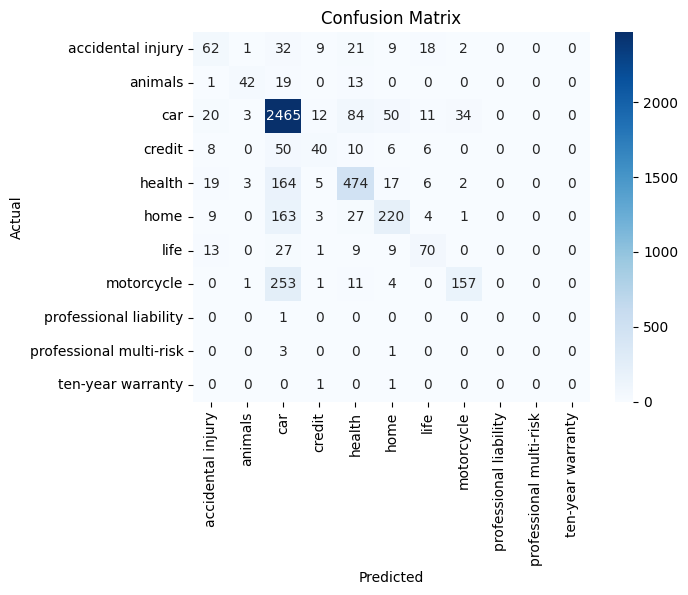

Random Forest Model:
Classification Report:


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                         precision    recall  f1-score   support

      accidental injury       1.00      0.03      0.06       154
                animals       1.00      0.07      0.12        75
                    car       0.63      0.99      0.77      2679
                 credit       1.00      0.01      0.02       120
                 health       0.70      0.37      0.48       690
                   home       0.93      0.16      0.28       427
                   life       1.00      0.02      0.03       129
             motorcycle       0.90      0.13      0.22       427
 professional liability       0.00      0.00      0.00         1
professional multi-risk       0.00      0.00      0.00         4
      ten-year warranty       0.00      0.00      0.00         2

               accuracy                           0.64      4708
              macro avg       0.65      0.16      0.18      4708
           weighted avg       0.73      0.64      0.56      4708

Confusion Matrix:


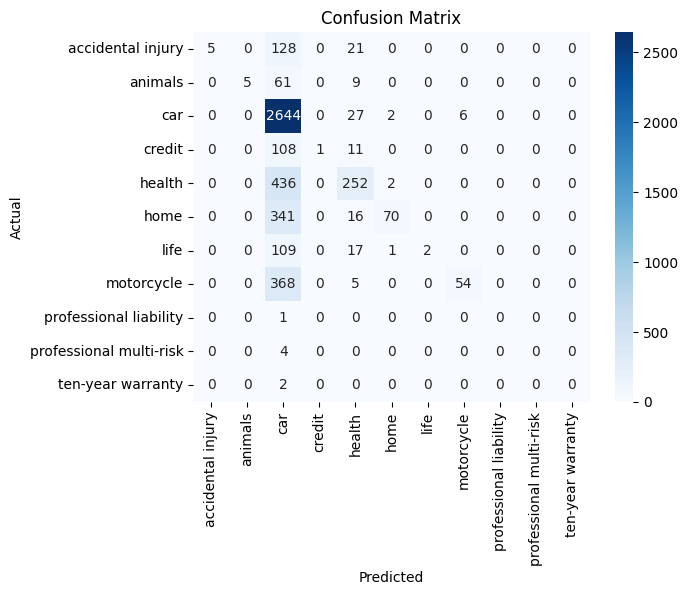

In [33]:
# Prepare data
X_train, X_test, y_train, y_test = data_prep_sentence_bert(processed_df)

# Train Logistic Regression model
lr_product = train_lr_model(X_train, y_train)

# Train Random Forest model
rf_product = train_rf_model(X_train, y_train)

# Evaluate Logistic Regression model
print("Logistic Regression Model:")
evaluate_model(lr_product, X_test, y_test, lr_product.classes_)

# Evaluate Random Forest model
print("Random Forest Model:")
evaluate_model(rf_product, X_test, y_test, rf_product.classes_)